In [2]:
!pip install mlxtend
!pip install -U scikit-learn

In [1]:
import keras.optimizers
import matplotlib
import tensorflow as tf
import random
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import *

In [2]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

seed = 22
tf.random.set_seed(seed)
random.seed(a=seed)
batch_size = 32

In [3]:
def read_data():
    with open("DATA.txt") as f:
        lines = f.readlines()

    input_data = np.empty(shape=(lines.__len__(), 2))
    for i in range(lines.__len__()):
        raw_data = lines[i].split(",")
        data0 = float(raw_data[0])
        data1 = float(raw_data[1])
        input_data[i][0] = data0
        input_data[i][1] = data1

    with open("TARGETS.txt") as f:
        lines = f.readlines()

    target_data = []
    for j in range(lines.__len__()):
        raw_line = lines[j].split(",")
        raw_data = []
        for k in range(raw_line.__len__()):
            raw_data.append(int(raw_line[k]))
        target_data.append(raw_data)

    return input_data, np.array(target_data)

In [4]:
def plot_data(data, title):
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    for aux in range(data.__len__()):
        points = data[aux]
        plt.plot(points[0], points[1], marker="o", markersize=5, markeredgecolor=points[2], markerfacecolor=points[2])
    # plt.scatter(x_data, y_data)
    plt.show()

In [5]:
def read_input():
    print(
        "Please insert the learning rate, percentage of data reserved for testing, percentage for validation, max epochs, neurons in hidden layer, early stop\n")
    print("Learning rate: ")
    try:
        learning = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Percentage of data reserved: ")
    try:
        reserved = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Percentage of data for validation: ")
    try:
        reserved_validation = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")
    print("Max epochs: ")
    try:
        epochs = int(input())
    except ValueError:
        raise TypeError("Expected Int, got wrong type!\n")
    print("Neurons in hidden layer: ")
    try:
        neurons = int(input())
    except ValueError:
        raise TypeError("Expected Int, got wrong type!\n")
    print("Error rate used as stop condition (100 - 0)")
    try:
        error_rate = float(input())
    except ValueError:
        raise TypeError("Expected Float, got wrong type!\n")

    return learning, reserved, epochs, reserved_validation, neurons, error_rate

In [6]:
def select_training_data(data_to_sort_through, target_data_to_sort_through, samples):
    result = np.empty(shape=(samples, 2))
    target_result = np.empty(shape=(samples, 3))
    data_not_chosen = np.empty(shape=((data_to_sort_through.shape[0] - samples), 2))
    target_data_not_chosen = np.empty(shape=((data_to_sort_through.shape[0] - samples), 3))
    index_of_data_chosen = []
    for i in range(samples):
        new = True
        while new:
            line = random.randrange(0, data_to_sort_through.__len__() - 1, 1)
            possible_new_element0 = data_to_sort_through[line][0]
            possible_new_element1 = data_to_sort_through[line][1]
            temp = [possible_new_element0, possible_new_element1]
            if temp not in result:
                result[i][0] = possible_new_element0
                result[i][1] = possible_new_element1
                element = target_data_to_sort_through[line]
                target_result[i][0] = element[0]
                target_result[i][1] = element[1]
                target_result[i][2] = element[2]
                new = False
                index_of_data_chosen.append(line)
    aux = 0
    for j in range(data_to_sort_through.shape[0]):
        if j not in index_of_data_chosen:
            data_not_chosen[aux][0] = data_to_sort_through[j][0]
            data_not_chosen[aux][1] = data_to_sort_through[j][1]
            element = target_data_to_sort_through[j]
            target_data_not_chosen[aux][0] = element[0]
            target_data_not_chosen[aux][1] = element[1]
            target_data_not_chosen[aux][2] = element[2]
            aux += 1

    return np.array(result), np.array(target_result), np.array(data_not_chosen), np.array(target_data_not_chosen)

In [7]:
def prepare_data_for_plot(x_data, y_data):
    data_to_plot = []
    for u in range(x_data.__len__()):
        point = [x_data[u][0], x_data[u][1]]
        if np.array_equal(y_data[u], [1, 0, 0]):
            point.append('green')
        elif np.array_equal(y_data[u], [0, 1, 0]):
            point.append('red')
        elif np.array_equal(y_data[u], [0, 0, 1]):
            point.append('blue')
        data_to_plot.append(point)
    return data_to_plot

In [8]:
def create_dataset(train_amount, val_amount):
    data, target = read_data()

    train_test_split = int(train_amount * data.__len__())
    train_test_split_complement = 1 - train_amount
    raw_train, raw_train_target, raw_test, raw_test_target = select_training_data(data, target, train_test_split)

    raw_train_target_list = []
    raw_test_target_list = []

    for aux in range(raw_train_target.__len__()):
        if np.array_equal(raw_train_target[aux], [1, 0, 0]):
            raw_train_target_list.append(0)
        elif np.array_equal(raw_train_target[aux], [0, 1, 0]):
            raw_train_target_list.append(1)
        elif np.array_equal(raw_train_target[aux], [0, 0, 1]):
            raw_train_target_list.append(2)
    raw_train_target_np = np.array(raw_train_target_list)

    for aux in range(raw_test_target.__len__()):
        if np.array_equal(raw_test_target[aux], [1, 0, 0]):
            raw_test_target_list.append(0)
        elif np.array_equal(raw_test_target[aux], [0, 1, 0]):
            raw_test_target_list.append(1)
        elif np.array_equal(raw_test_target[aux], [0, 0, 1]):
            raw_test_target_list.append(2)
    raw_test_target_np = np.array(raw_test_target_list)

    # train = tf.data.Dataset.from_tensor_slices((raw_train, raw_train_target_np), 'training')
    # test = tf.data.Dataset.from_tensor_slices((raw_test, raw_test_target_np), 'test')
    return raw_train, raw_train_target, raw_test, raw_test_target, raw_train_target_np, raw_test_target_np

In [9]:
def plot_metric(history_data, metric):
    train_metrics = history_data.history[metric]
    val_metrics = history_data.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [10]:
learning_rate, percentage_reserved, max_epochs, reserved_for_validation, hidden_neurons, acceptable_error = read_input()

Please insert the learning rate, percentage of data reserved for testing, percentage for validation, max epochs, neurons in hidden layer, early stop

Learning rate: 
Percentage of data reserved: 
Percentage of data for validation: 
Max epochs: 
Neurons in hidden layer: 
Error rate used as stop condition (100 - 0)


In [11]:
train_x, learning_target_dataset, test_x, testing_target_dataset, train_y, test_y = create_dataset(percentage_reserved, reserved_for_validation)

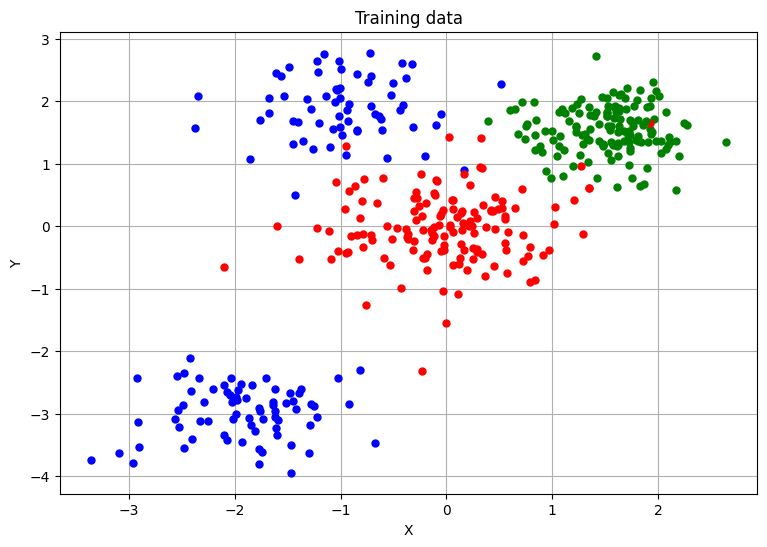

In [12]:
plot_data(prepare_data_for_plot(train_x, learning_target_dataset), "Training data")

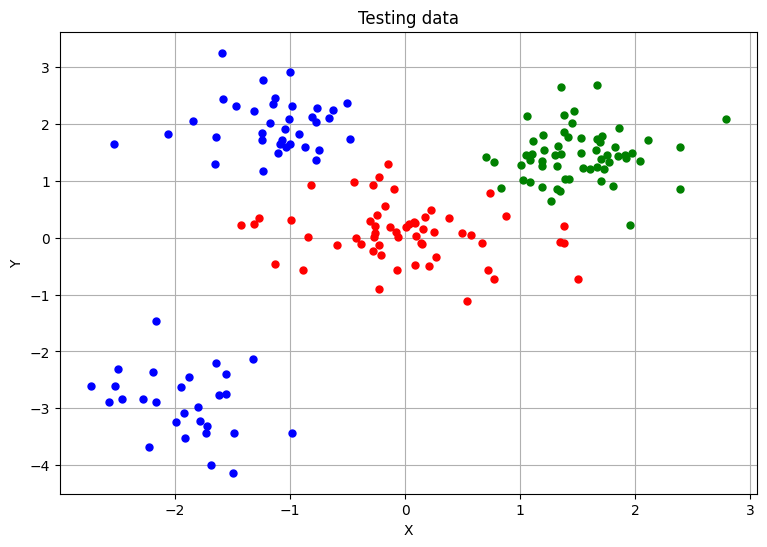

In [13]:
plot_data(prepare_data_for_plot(test_x, testing_target_dataset), "Testing data")

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [16]:
inputs = tf.keras.Input(shape=(2,), name='coordinates')
x = tf.keras.layers.Dense(hidden_neurons, activation='relu', name='hidden_1')(inputs)
outputs = tf.keras.layers.Dense(3, activation='softmax', name='predictions')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [22]:
history = model.fit(train_x, train_y, batch_size=32, epochs=max_epochs, callbacks=callback, validation_split=reserved_for_validation, use_multiprocessing=True)

Epoch 1/200
10/10 [==============================] - 0s 13ms/step - loss: 0.0942 - accuracy: 0.9762 - val_loss: 0.1537 - val_accuracy: 0.9524
Epoch 2/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.9762 - val_loss: 0.1531 - val_accuracy: 0.9524
Epoch 3/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0930 - accuracy: 0.9762 - val_loss: 0.1527 - val_accuracy: 0.9524
Epoch 4/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0924 - accuracy: 0.9762 - val_loss: 0.1521 - val_accuracy: 0.9524
Epoch 5/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0918 - accuracy: 0.9762 - val_loss: 0.1520 - val_accuracy: 0.9524
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.0914 - accuracy: 0.9762 - val_loss: 0.1520 - val_accuracy: 0.9524
Epoch 7/200
10/10 [==============================] - 0s 9ms/step - loss: 0.0908 - accuracy: 0.9762 - val_loss: 0.1511 - val_accuracy: 0.9524
Epoch 8/200


In [23]:
test_results = model.evaluate(test_x, test_y, use_multiprocessing=True)

6/6 [==============================] - 0s 1ms/step - loss: 0.0629 - accuracy: 0.9833


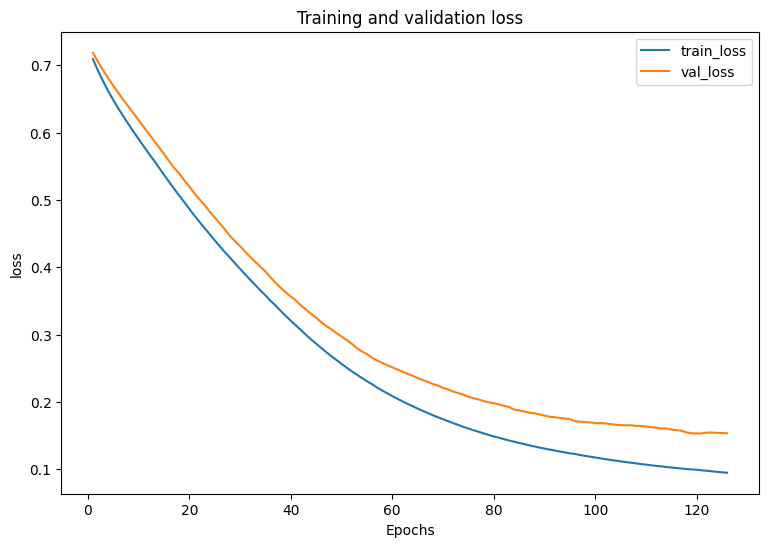

In [20]:
plot_metric(history, 'loss')

6/6 [==============================] - 0s 3ms/step


(<Figure size 900x600 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

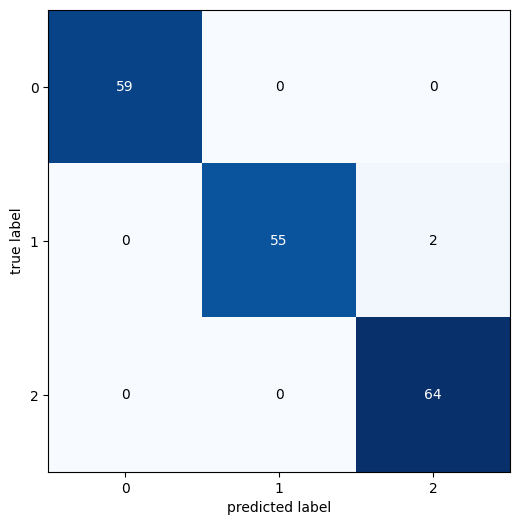

In [21]:
predictions = model.predict(test_x)

result = confusion_matrix(test_y, predictions.argmax(axis=1))
plot_confusion_matrix(result)